#### Import required packages

In [4]:
# numeric and plotting libraries
import time
import os
import shutil
import math
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np
import csv
import random
from PIL import Image
import csv
import operator 
import pandas as pd 
# to create confusion metrics
import seaborn as sns
import scipy.io as sio
import scipy.stats as stats
from cmath import nan
from cmath import isnan
import warnings
warnings.filterwarnings("ignore")
from numpy import isinf
import signal
from sklearn.decomposition import PCA

In [ ]:
from  ipynb.fs.full.data_prep import *

In [3]:
%matplotlib inline

In [6]:
from sklearn.metrics import accuracy_score,confusion_matrix # metrics error
from sklearn.multiclass import OneVsRestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from numpy import loadtxt
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import xgboost as xgb

# Classification on anest and awake state

#### Data preparation

In [7]:
def load_data(directory):
    data = []
    for filename in os.listdir(directory):
        # example: aw_mouse3_roi1_ses3_tr21.npy
        f = os.path.join(directory, filename)
        
        list_of_subs = f.split("\\")[-1].split("_")
        list_of_subs[-1] = list_of_subs[-1][:-4]

        # get all numeric values from the filename
        for i in range(len(list_of_subs)):
            if list_of_subs[i][-2:].isdigit():
                list_of_subs[i] = int(list_of_subs[i][-2:])
            elif list_of_subs[i][-1].isdigit():
                list_of_subs[i] = int(list_of_subs[i][-1])
                
        if list_of_subs[0] == 'aw':
            list_of_subs[0] = 0
        elif list_of_subs[0] == 'an':
            list_of_subs[0] = 1

        all_info = {'label': list_of_subs[0], 'mouse': list_of_subs[1], 'roi': list_of_subs[2], 'ses': list_of_subs[3], 'tr': list_of_subs[4]}
        
        # load actual data
        dat = np.load(f)

        # append new data to the list
        data.append([all_info, dat])
    
    return data      

In [8]:
def train_test_split(mouse_id, data_vectors):
    train_data, train_labels, test_data, test_labels = [], [], [], []
    for data in data_vectors:
        if data[0]['mouse'] == mouse_id:
            test_data.append(data[1])
            test_labels.append(data[0]['label'])
        else:
            train_data.append(data[1])
            train_labels.append(data[0]['label'])

    # shuffle train data
    c = list(zip(train_data, train_labels))
    random.shuffle(c)
    train_data, train_labels = zip(*c)

    # shuffle test data
    c = list(zip(test_data, test_labels))
    random.shuffle(c)
    test_data, test_labels = zip(*c)
    
    return train_data, train_labels, test_data, test_labels

In [9]:
path = "C:/Users/Zephyrus/Marija/projekti/MINHEN/an_aw/data"
load_all_data = load_data(path)

In [8]:
train_data, train_labels, test_data, test_labels = train_test_split(1, load_all_data)

In [9]:
print('Train len:',len(train_data), 'Test len:', len(test_data))
print('Shape of the initial data sample:', train_data[1000].shape)
print('Train labels 0/an:', len(train_labels)-np.sum(train_labels), 'Train labels 1/aw:', np.sum(train_labels))
print('Test labels 0/an:', len(test_labels)-np.sum(test_labels), 'Test labels 1/aw:', np.sum(test_labels))

Train len: 4000 Test len: 800
Shape of the initial data sample: (81, 5, 31)
Train labels 0/an: 2000 Train labels 1/aw: 2000
Test labels 0/an: 400 Test labels 1/aw: 400


In [10]:
def process_data(sp, tr_data, ts_data):
    for i in range(len(tr_data)):
        tr_data[i] = tr_data[i][:,sp,10:].flatten()
    for i in range(len(ts_data)):
        ts_data[i] = ts_data[i][:,sp,10:].flatten()

    max_len_tr = max([len(i) for i in tr_data])
    max_len_ts = max([len(i) for i in ts_data])
    max_len = max(max_len_tr, max_len_ts)

    # fill with zeros float64
    for i in range(len(tr_data)):
        tr_data[i] = np.append(tr_data[i], np.zeros(max_len - len(tr_data[i])))
    for i in range(len(ts_data)):
        ts_data[i] = np.append(ts_data[i], np.zeros(max_len - len(ts_data[i])))

    tr_data = [list(i) for i in tr_data]
    ts_data = [list(i) for i in ts_data]

    return tr_data, ts_data

In [76]:
def extract_features(tr_data, ts_data, tr_labels, ts_labels):
    power_tr, power_ts = [], []
    del_list = []
 
    for i in range(len(tr_data)):
        one_sample = []
        y = 0
        for sp in range(0,5):
            signal_neurons = tr_data[i][:,sp,:].flatten()
            if len(signal_neurons) == 0:
                del_list.append(i)
                y = 1
                continue

            # power spectrum
            signal_power = np.abs(np.fft.fft(signal_neurons))**2
            one_sample.append(np.max(signal_power))
            one_sample.append(np.min(signal_power))
            one_sample.append(np.std(signal_power))
            # kurtosis
            kurt = stats.kurtosis(signal_power)
            if isnan(kurt) or isinf(kurt): kurt = 0
            one_sample.append(kurt)
            # skewness
            skew = stats.skew(signal_power)
            if isnan(skew) or isinf(skew): skew = 0
            one_sample.append(skew)
            # entropy
            ent = stats.entropy(signal_power)
            if isnan(ent) or isinf(ent): ent = 0
            one_sample.append(ent)
            # average spike rate
            avg_spike_rate = np.mean(signal_power)
            if isnan(avg_spike_rate) or isinf(avg_spike_rate): avg_spike_rate = 0
            one_sample.append(avg_spike_rate)
            # burstiness
            burst = np.max(signal_power) / avg_spike_rate
            if isnan(burst) or isinf(burst): burst = 0
            one_sample.append(burst)
            # pattern
            pattern = np.max(signal_power) / np.mean(signal_power)
            if isnan(pattern) or isinf(pattern): pattern = 0
            one_sample.append(pattern)

        if y == 0:
            power_tr.append(one_sample)

    tr_labels = np.delete(tr_labels, del_list)
    del_list = []  

    for i in range(len(ts_data)):
        one_sample = []
        y = 0
        for sp in range(0,5):
            signal_neurons = ts_data[i][:,sp,:].flatten()
            if len(signal_neurons) == 0:
                del_list.append(i)
                y = 1
                continue

            # power spectrum
            signal_power = np.abs(np.fft.fft(signal_neurons))**2
            one_sample.append(np.max(signal_power))
            one_sample.append(np.min(signal_power))
            one_sample.append(np.std(signal_power))  
            # kurtosis
            kurt = stats.kurtosis(signal_power)
            if isnan(kurt) or isinf(kurt): kurt = 0
            one_sample.append(kurt)
            # skewness
            skew = stats.skew(signal_power)
            if isnan(skew) or isinf(skew): skew = 0
            one_sample.append(skew)
            # entropy
            ent = stats.entropy(signal_power)
            if isnan(ent) or isinf(ent): ent = 0
            one_sample.append(ent)
            # average spike rate
            avg_spike_rate = np.mean(signal_power)
            if isnan(avg_spike_rate) or isinf(avg_spike_rate): avg_spike_rate = 0
            one_sample.append(avg_spike_rate)
            # burstiness
            burst = np.max(signal_power) / avg_spike_rate
            if isnan(burst) or isinf(burst): burst = 0
            one_sample.append(burst)
            # pattern
            pattern = np.max(signal_power) / np.mean(signal_power)
            if isnan(pattern) or isinf(pattern): pattern = 0
            one_sample.append(pattern)
            
        if y == 0:
            power_ts.append(one_sample)

    ts_labels = np.delete(ts_labels, del_list)

    return power_tr, power_ts, tr_labels, ts_labels

In [77]:
train_data_proc, test_data_proc, train_labels_proc, test_labels_proc = extract_features(train_data, test_data, train_labels, test_labels)

In [149]:
train_data_proc, test_data_proc = process_data(np.array(train_data), np.array(test_data))

In [59]:
print(len(train_data_proc), len(test_data_proc), len(train_labels_proc), len(test_labels_proc))
print(len(train_data_proc[0]), len(test_data_proc[0]))

3996 799 3996 799
45 45


# KNN

In [29]:
accs = []
conf_mats = []
for i in range(1, 11):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(train_data_proc, train_labels_proc)
    knn_pred = knn.predict(test_data_proc)
    accs.append(accuracy_score(test_labels_proc, knn_pred))
    conf_mats.append(confusion_matrix(test_labels_proc, knn_pred))

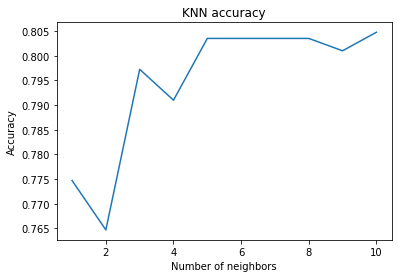

In [30]:
plt.plot(range(1, 11), accs)
plt.xlabel('Number of neighbors')
plt.ylabel('Accuracy')
plt.title('KNN accuracy')
plt.show()

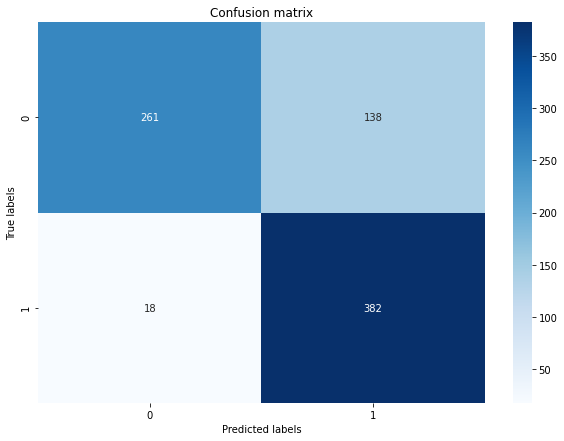

In [31]:
# confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_mats[accs.index(max(accs))], annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion matrix')
plt.show()

# RANDOM FOREST

### One speaker, time point from 10th

In [320]:
accs, conf_mats = [], []

for mouse in range(1,7):
    tr_data, tr_labels, ts_data, ts_labels = train_test_split(mouse, load_all_data)
    accs_mouse, conf_mats_mouse = [], []

    for speaker in range(0, 5):
        tr_data_proc, ts_data_proc = process_data(speaker, tr_data, ts_data)
        rf = RandomForestClassifier(n_estimators=100)
        rf.fit(tr_data_proc, tr_labels)
        rf_pred = rf.predict(ts_data_proc)
    
        accs_mouse.append(accuracy_score(ts_labels, rf_pred))
        conf_mats_mouse.append(confusion_matrix(ts_labels, rf_pred))
    
    accs.append(accs_mouse)
    conf_mats.append(conf_mats_mouse)

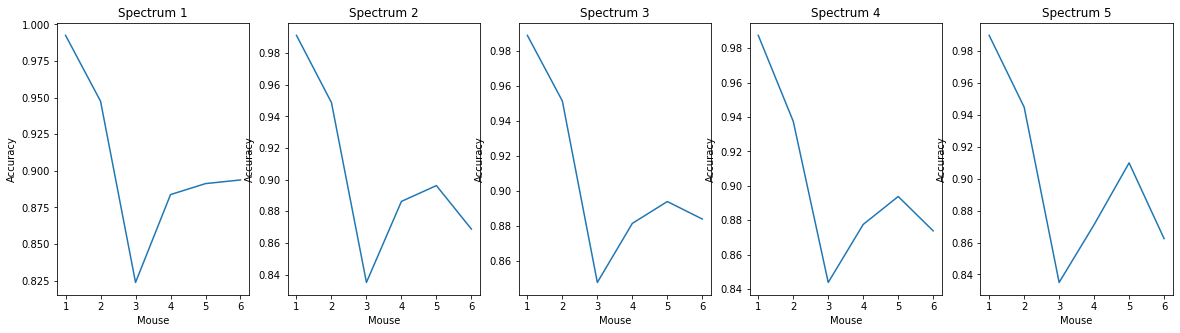

In [194]:
fig, ax = plt.subplots(1, 5, figsize=(20, 5))
for i in range(5):
    ax[i].plot(range(1, 7), [accs[j][i] for j in range(6)])
    ax[i].set_xlabel('Mouse')
    ax[i].set_ylabel('Accuracy')
    ax[i].set_title('Spectrum ' + str(i+1))
plt.show()

In [205]:
print('Average accuracies per speaker:')
for i in range(5):
    print('Speaker', i+1, ':', np.mean([accs[j][i] for j in range(6)]))
print('')

print('Avevrage accuracies per mouse:')
for i in range(6):
    print('Mouse', i+1, ':', np.mean(accs[i]))

accs

Average accuracies per speaker:
Speaker 1 : 0.9054166666666666
Speaker 2 : 0.904375
Speaker 3 : 0.9077083333333333
Speaker 4 : 0.9022916666666667
Speaker 5 : 0.9022916666666666

Avevrage accuracies per mouse:
Mouse 1 : 0.99
Mouse 2 : 0.9460000000000001
Mouse 3 : 0.8370000000000001
Mouse 4 : 0.8800000000000001
Mouse 5 : 0.897
Mouse 6 : 0.8765000000000001


[[0.9925, 0.99125, 0.98875, 0.9875, 0.99],
 [0.9475, 0.94875, 0.95125, 0.9375, 0.945],
 [0.82375, 0.835, 0.8475, 0.84375, 0.835],
 [0.88375, 0.88625, 0.88125, 0.8775, 0.87125],
 [0.89125, 0.89625, 0.89375, 0.89375, 0.91],
 [0.89375, 0.86875, 0.88375, 0.87375, 0.8625]]

### All speakers, all time points

In [211]:
accs, conf_mats = [], []
accs_mouse, conf_mats_mouse = [], []
for mouse in range(1,7):
    tr_data, tr_labels, ts_data, ts_labels = train_test_split(mouse, load_all_data)
    tr_data_proc, ts_data_proc = process_data(sp, np.array(tr_data), np.array(ts_data))

    rf = RandomForestClassifier(n_estimators=100)
    rf.fit(tr_data_proc, tr_labels)
    rf_pred = rf.predict(ts_data_proc)
    
    accs_mouse.append(accuracy_score(ts_labels, rf_pred))
    conf_mats_mouse.append(confusion_matrix(ts_labels, rf_pred))


In [214]:
accs_mouse

[0.99125, 0.96125, 0.8725, 0.8825, 0.90625, 0.8575]

### Extracted fetures

In [78]:
rf = RandomForestClassifier(n_estimators=100)
rf.fit(train_data_proc, train_labels_proc)
rf_pred = rf.predict(test_data_proc)
accuracy_score(test_labels_proc, rf_pred)

0.9899874843554443

In [94]:
accs_mouse, conf_mats_mouse = [], []

for mouse in range(1,7):
    tr_data, tr_labels, ts_data, ts_labels = train_test_split(mouse, load_all_data)
    tr_data_proc, ts_data_proc, tr_labels, ts_labels = extract_features(tr_data, ts_data, tr_labels, ts_labels)

    rf = RandomForestClassifier(n_estimators=100)
    rf.fit(tr_data_proc, tr_labels)
    rf_pred = rf.predict(ts_data_proc)
    
    accs_mouse.append(accuracy_score(ts_labels, rf_pred))
    conf_mats_mouse.append(confusion_matrix(ts_labels, rf_pred))

In [ ]:
accs_mouse

(-1.0, 10.0)

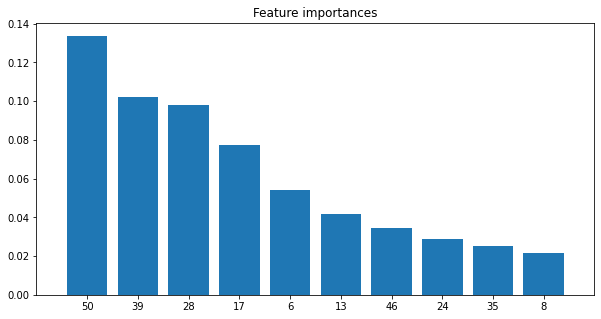

In [83]:
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]

#select 10 most important features
indices = indices[:10]

#plot
plt.figure(figsize=(10, 5))
plt.title("Feature importances")
plt.bar(range(10), importances[indices], align="center")
plt.xticks(range(10), indices)
plt.xlim([-1, 10])

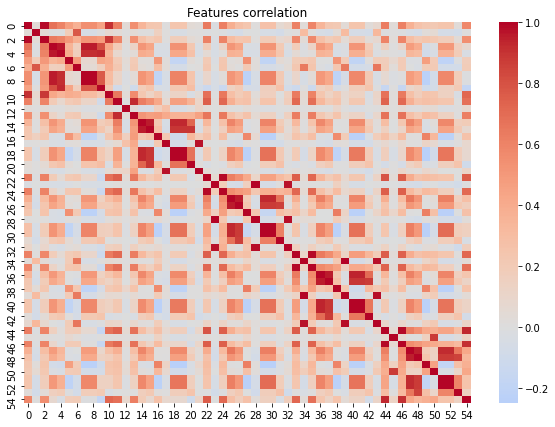

In [82]:
plt.figure(figsize=(10, 7))
sns.heatmap(np.corrcoef(tr_data_proc, rowvar=False), cmap='coolwarm', center=0)
plt.title('Features correlation')
plt.show()

## Classification on 5 different speakers

In [134]:
def train_test_split_speakers(mouse_id, data_vectors):
    train_data, train_labels, test_data, test_labels = [], [], [], []
    for data in data_vectors:
        if data[0]['label'] == 0:
            if data[0]['mouse'] == mouse_id:
                all_sp_data = data[1]
                test_data.append(all_sp_data[:,0,:])
                test_labels.append(0)
                test_data.append(all_sp_data[:,1,:])
                test_labels.append(1)
            else:
                all_sp_data = data[1]
                train_data.append(all_sp_data[:,0,:])
                train_labels.append(0)
                train_data.append(all_sp_data[:,1,:])
                train_labels.append(1)

    # shuffle train data
    c = list(zip(train_data, train_labels))
    random.shuffle(c)
    train_data, train_labels = zip(*c)

    # shuffle test data
    c = list(zip(test_data, test_labels))
    random.shuffle(c)
    test_data, test_labels = zip(*c)

    return train_data, train_labels, test_data, test_labels

In [135]:
trd, trl, tsd, tsl = train_test_split_speakers(1, load_all_data)

In [111]:
print('Train len:',len(trd), 'Test len:', len(tsd))
print(set(trl), set(tsl))

Train len: 4000 Test len: 800
{0, 1} {0, 1}


In [112]:
def extract_features(tr_data, ts_data, tr_labels, ts_labels):
    power_tr_all, power_ts_all = [], []
    del_list = []
 
    for i in range(len(tr_data)):
        power_tr = []
        y = 0
        
        signal_neurons = tr_data[i].flatten()
        if len(signal_neurons) == 0:
            del_list.append(i)
            y = 1
            continue

        # power spectrum
        signal_power = np.abs(np.fft.fft(signal_neurons))**2
        power_tr.append(np.max(signal_power))
        power_tr.append(np.min(signal_power))
        power_tr.append(np.std(signal_power))
        # kurtosis
        kurt = stats.kurtosis(signal_power)
        if isnan(kurt) or isinf(kurt): kurt = 0
        power_tr.append(kurt)
        # skewness
        skew = stats.skew(signal_power)
        if isnan(skew) or isinf(skew): skew = 0
        power_tr.append(skew)
        # entropy
        ent = stats.entropy(signal_power)
        if isnan(ent) or isinf(ent): ent = 0
        power_tr.append(ent)
        # average spike rate
        avg_spike_rate = np.mean(signal_power)
        if isnan(avg_spike_rate) or isinf(avg_spike_rate): avg_spike_rate = 0
        power_tr.append(avg_spike_rate)
        # burstiness
        burst = np.max(signal_power) / avg_spike_rate
        if isnan(burst) or isinf(burst): burst = 0
        power_tr.append(burst)
        # pattern
        pattern = np.max(signal_power) / np.mean(signal_power)
        if isnan(pattern) or isinf(pattern): pattern = 0
        power_tr.append(pattern)

        if y == 0:
            power_tr_all.append(power_tr)

    tr_labels = np.delete(tr_labels, del_list)
    del_list = []  

    for i in range(len(ts_data)):
        power_ts = []
        y = 0
        signal_neurons = ts_data[i].flatten()
        if len(signal_neurons) == 0:
            del_list.append(i)
            y = 1
            continue

        # power spectrum
        signal_power = np.abs(np.fft.fft(signal_neurons))**2
        power_ts.append(np.max(signal_power))
        power_ts.append(np.min(signal_power))
        power_ts.append(np.std(signal_power))  
        # kurtosis
        kurt = stats.kurtosis(signal_power)
        if isnan(kurt) or isinf(kurt): kurt = 0
        power_ts.append(kurt)
        # skewness
        skew = stats.skew(signal_power)
        if isnan(skew) or isinf(skew): skew = 0
        power_ts.append(skew)
        # entropy
        ent = stats.entropy(signal_power)
        if isnan(ent) or isinf(ent): ent = 0
        power_ts.append(ent)
        # average spike rate
        avg_spike_rate = np.mean(signal_power)
        if isnan(avg_spike_rate) or isinf(avg_spike_rate): avg_spike_rate = 0
        power_ts.append(avg_spike_rate)
        # burstiness
        burst = np.max(signal_power) / avg_spike_rate
        if isnan(burst) or isinf(burst): burst = 0
        power_ts.append(burst)
        # pattern
        pattern = np.max(signal_power) / np.mean(signal_power)
        if isnan(pattern) or isinf(pattern): pattern = 0
        power_ts.append(pattern)

        if y == 0:
            power_ts_all.append(power_ts)

    ts_labels = np.delete(ts_labels, del_list)

    return power_tr_all, power_ts_all, tr_labels, ts_labels

In [151]:
def extract_features(tr_data, ts_data, tr_labels, ts_labels):
    power_tr_all, power_ts_all = [], []
    del_list = []
 
    for i in range(len(tr_data)):
        power_tr = []
        
        # correlation between neurons in tr_data[i]
        corr = np.corrcoef(tr_data[i])
        # exclude all raw with all nans and columns with all nans from corr
        corr = corr[~np.all(np.isnan(corr), axis=1)]
        corr = corr[:, ~np.all(np.isnan(corr), axis=0)]

        if len(corr.flatten()) == 0:
            del_list.append(i)
            continue

        maxs, mins, stds, means = [], [], [], []
        for neuron in corr:
            maxs.append(np.max(neuron))
            mins.append(np.min(neuron))
            stds.append(np.std(neuron))
            means.append(np.mean(neuron))
        '''
        power_tr.append(np.max(maxs))
        power_tr.append(np.min(maxs))
        power_tr.append(np.std(maxs))
        power_tr.append(np.mean(maxs))
        power_tr.append(np.max(mins))
        power_tr.append(np.min(mins))
        power_tr.append(np.std(mins))
        power_tr.append(np.mean(mins))
        power_tr.append(np.max(stds))
        power_tr.append(np.min(stds))
        power_tr.append(np.std(stds))
        power_tr.append(np.mean(stds))
        power_tr.append(np.max(means))
        power_tr.append(np.min(means))
        power_tr.append(np.std(means))
        power_tr.append(np.mean(means))
        '''
        #concat maxs, mins, stds, means
        power_tr = maxs + mins + stds + means

        power_tr_all.append(power_tr)

    tr_labels = np.delete(tr_labels, del_list)
    del_list = []  

    for i in range(len(ts_data)):
        power_ts = []

        # correlation between neurons in ts_data[i]
        corr = np.corrcoef(ts_data[i], rowvar=False)
        # exclude all raw with all nans and columns with all nans from corr
        corr = corr[~np.all(np.isnan(corr), axis=1)]
        corr = corr[:, ~np.all(np.isnan(corr), axis=0)]
        
        if len(corr.flatten()) == 0:
            del_list.append(i)
            continue
        
        maxs, mins, stds, means = [], [], [], []
        for neuron in corr:
            maxs.append(np.max(neuron)) 
            mins.append(np.min(neuron))
            stds.append(np.std(neuron))
            means.append(np.mean(neuron))

        '''
        power_ts.append(np.max(maxs))
        power_ts.append(np.min(maxs))
        power_ts.append(np.std(maxs))
        power_ts.append(np.mean(maxs))
        power_ts.append(np.max(mins))
        power_ts.append(np.min(mins))
        power_ts.append(np.std(mins))
        power_ts.append(np.mean(mins))
        power_ts.append(np.max(stds))
        power_ts.append(np.min(stds))
        power_ts.append(np.std(stds))
        power_ts.append(np.mean(stds))
        power_ts.append(np.max(means))
        power_ts.append(np.min(means))
        power_ts.append(np.std(means))
        power_ts.append(np.mean(means))
        '''

        #concat maxs, mins, stds, means
        power_ts = maxs + mins + stds + means
        
        power_ts_all.append(power_ts)

    ts_labels = np.delete(ts_labels, del_list)

    max_len_tr = max([len(i) for i in power_tr_all])
    max_len_ts = max([len(i) for i in power_ts_all])
    max_len = max(max_len_tr, max_len_ts)

    # fill with zeros float64
    for i in range(len(power_tr_all)):
        power_tr_all[i] = np.append(power_tr_all[i], np.zeros(max_len - len(power_tr_all[i]))) 
    for i in range(len(power_ts_all)):
        power_ts_all[i] = np.append(power_ts_all[i], np.zeros(max_len - len(power_ts_all[i])))

    power_tr_all = [list(i) for i in power_tr_all]
    power_ts_all = [list(i) for i in power_ts_all]

    return power_tr_all, power_ts_all, tr_labels, ts_labels

In [146]:
def process_data(tr_data, ts_data):

    tr_data = [np.array(i) for i in tr_data]
    ts_data = [np.array(i) for i in ts_data]
    tr_data = np.array(tr_data)
    ts_data = np.array(ts_data)
    
    for i in range(len(tr_data)):
        tr_data[i] = tr_data[i][:,10:].flatten()
    for i in range(len(ts_data)):
        ts_data[i] = ts_data[i][:,10:].flatten()

    max_len_tr = max([len(i) for i in tr_data])
    max_len_ts = max([len(i) for i in ts_data])
    max_len = max(max_len_tr, max_len_ts)

    # fill with zeros float64
    for i in range(len(tr_data)):
        tr_data[i] = np.append(tr_data[i], np.zeros(max_len - len(tr_data[i])))
    for i in range(len(ts_data)):
        ts_data[i] = np.append(ts_data[i], np.zeros(max_len - len(ts_data[i])))

    tr_data = [list(i) for i in tr_data]
    ts_data = [list(i) for i in ts_data]

    return tr_data, ts_data

In [158]:
trd, trl, tsd, tsl = train_test_split_speakers(5, load_all_data)
train_data_proc, test_data_proc, trl, tsl = extract_features(trd, tsd, trl, tsl)
#train_data_proc, test_data_proc = process_data(trd, tsd)

In [159]:
print(len(train_data_proc), len(test_data_proc), len(trl), len(tsl))

3391 727 3391 727


In [160]:
rf = RandomForestClassifier(n_estimators=100)
rf.fit(train_data_proc, trl)
rf_pred = rf.predict(test_data_proc)
accuracy_score(tsl, rf_pred)

0.5116918844566712

In [161]:
xgb = XGBClassifier()
xgb.fit(train_data_proc, trl)
xgb_pred = xgb.predict(test_data_proc)
accuracy_score(tsl, xgb_pred)

[20:51:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


0.4938101788170564

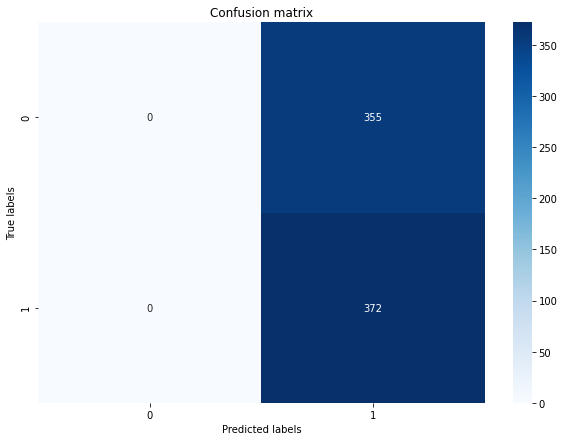

In [162]:
conf_mats = []
conf_mats.append(confusion_matrix(tsl, rf_pred))
plt.figure(figsize=(10, 7))
sns.heatmap(conf_mats[0], annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion matrix')
plt.show()

# STARO

In [9]:
def podela_podataka(data_vectors):
    max = 0
    for i in range(0,len(data_vectors)):
        if(data_vectors[i][1].shape[0] > max):
            max = data_vectors[i][1].shape[0]

    X_train, y_train, X_test, y_test = np.empty([1, max, data_vectors[0][1].shape[1]]), [], np.empty([1, max, data_vectors[0][1].shape[1]]),[]
    i,j = 0,0

    max_norm = 0
    min_norm = 50
    for a in data_vectors:
        for x in a[1]:
            for y in x:
                if(y > max_norm):
                    max_norm = y
                if(y < min_norm):
                    min_norm = y

    for a in range(0, len(data_vectors)):
        for x in range(0, len(data_vectors[a][1])):
            for y in range(0, len(data_vectors[a][1][x])):
                data_vectors[a][1][x][y] = (data_vectors[a][1][x][y] - min_norm) / (max_norm - min_norm)

    random.shuffle(data_vectors)
    for item in data_vectors:
        if item[2]==[1]:
            i = i + 1
            if i <= 50:
                if(np.array(item[1]).shape[0] < max):
                    item[1] = np.pad(item[1], [(0, max-np.array(item[1]).shape[0]), (0, 0)], mode='constant' , constant_values=0)
                X_test = np.append(X_test, np.array(item[1]).reshape(1, item[1].shape[0], np.array(item[1]).shape[1]), axis=0)
                y_test.append(item[2])
                #y_test.append(random.choice([[0], [1]]))
            else:
                if(np.array(item[1]).shape[0] < max):
                    item[1] = np.pad(item[1], [(0, max-np.array(item[1]).shape[0]), (0, 0)], mode='constant', constant_values=0)
                X_train = np.append(X_train, np.array(item[1]).reshape(1, np.array(item[1]).shape[0], np.array(item[1]).shape[1]), axis=0)
                y_train.append(item[2])
        else:
            j = j + 1
            if  j <= 50:
                if(np.array(item[1]).shape[0] < max):
                    item[1] = np.pad(item[1], [(0, max-np.array(item[1]).shape[0]), (0, 0)], mode='constant', constant_values=0)
                X_test = np.append(X_test, np.array(item[1]).reshape(1, np.array(item[1]).shape[0], np.array(item[1]).shape[1]), axis=0)
                y_test.append(item[2])
                #y_test.append(random.choice([[0], [1]]))
            else:
                if(np.array(item[1]).shape[0] < max):
                    item[1] = np.pad(item[1], [(0, max-np.array(item[1]).shape[0]), (0, 0)], mode='constant', constant_values=0)
                X_train = np.append(X_train, np.array(item[1]).reshape(1, np.array(item[1]).shape[0], np.array(item[1]).shape[1]), axis=0)
                y_train.append(item[2])
    
    X_train = np.array(X_train[1:])
    y_train = np.array(y_train)
    X_test = np.array(X_test[1:])
    y_test = np.array(y_test)
    
    return X_train, y_train, X_test, y_test

In [10]:
def podela_podataka_tren(data_vectors):
    max = 110
    X_train, y_train = np.empty([1, max, data_vectors[0][1].shape[1]]), []

    max_norm = 0
    min_norm = 50
    for a in data_vectors:
        for x in a[1]:
            for y in x:
                if(y > max_norm):
                    max_norm = y
                if(y < min_norm):
                    min_norm = y

    for a in range(0, len(data_vectors)):
        for x in range(0, len(data_vectors[a][1])):
            for y in range(0, len(data_vectors[a][1][x])):
                data_vectors[a][1][x][y] = (data_vectors[a][1][x][y] - min_norm) / (max_norm - min_norm)

    random.shuffle(data_vectors)

    for item in data_vectors:
        if(item[1].shape[0] < max):
            item[1] = np.pad(item[1], [(0, max-item[1].shape[0]), (0, 0)], mode='constant', constant_values=0)      
        X_train = np.append(X_train, item[1].reshape(1, item[1].shape[0], item[1].shape[1]), axis=0)
        #y_train.append(item[2])
        y_train.append(random.choice([[0], [1]]))
    
    X_train = np.array(X_train[1:])
    y_train = np.array(y_train)
    
    return X_train, y_train

#### Test/Train

In [ ]:
#putanja = "C:/Users/Zephyrus/Desktop/cnn data/data"
putanja = "C:/Users/Zephyrus/Marija/projekti/MINHEN/cnn data/data"
#niz od podataka za svaku sekvencu (podatak je niz od id-ja, sekvence i labele)
podaci = ucitavanje_podataka(putanja)
vektorizovani_podaci = vektorizacija(podaci)

X_train, y_train, X_test, y_test = podela_podataka(vektorizovani_podaci)
X_train = np.array(X_train, dtype=object)
y_train = np.array(y_train)
X_test = np.array(X_test, dtype=object)
y_test = np.array(y_test)

In [ ]:
X_tr = []
for i in X_train:
    temp = []
    for j in i:
        for k in j:
            if(isnan(k)):
                k = 0
            temp.append(k)
    X_tr.append(temp)
X_train = np.array(X_tr, dtype=object)

X_ts = []
for i in X_test:
    temp = []
    for j in i:
        for k in j:
            if(isnan(k)):
                k = 0
            temp.append(k)
    X_ts.append(temp) 
X_test = np.array(X_ts, dtype=object)

### KNN

In [ ]:
knn = OneVsRestClassifier(KNeighborsClassifier())
knn.fit(X_train,y_train)

OneVsRestClassifier(estimator=KNeighborsClassifier())

In [ ]:
predictions = knn.predict(X_test)

In [ ]:
print('KNN Accuracy: %.3f' % accuracy_score(y_test,predictions))

KNN Accuracy: 1.000


Text(0.5, 1.0, 'Accuracy Score: 1.0')

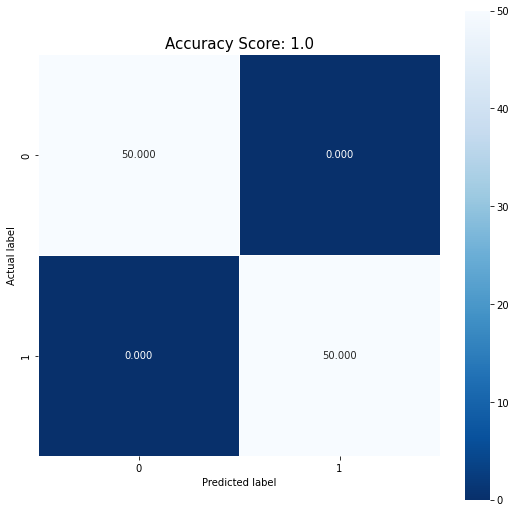

In [ ]:
cm = confusion_matrix(y_test,predictions)
plt.figure(figsize=(9,9))
sns.heatmap(cm,annot=True, fmt='.3f', linewidths=.5, square=True,cmap='Blues_r')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
all_sample_title = 'Accuracy Score: {0}'.format(accuracy_score(y_test,predictions))
plt.title(all_sample_title,size=15)

### Random Forest

##### Implementation

In [690]:
def RF(X_train, y_train, X_test, y_test):
    forest = RandomForestClassifier(criterion='gini',
                                    n_estimators=5,
                                    random_state=1,
                                    n_jobs=2)

    forest.fit(X_train, y_train)

    y_pred = forest.predict(X_test)

    print('Accuracy: %.3f' % accuracy_score(y_test, y_pred))
    
    return y_pred

In [691]:
def mat_of_conf(y_test,y_pred,br1,br2):
    cm = confusion_matrix(y_test,y_pred)

    plt.figure(figsize=(9,9))
    sns.heatmap(cm,annot=True, fmt='.3f', linewidths=.5, square=True,cmap='Blues_r')
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    all_sample_title = 'Accuracy Score: {0}'.format(accuracy_score(y_test,y_pred))
    plt.title(all_sample_title,size=15)
    plt.savefig("C:/Users/m.nedeljkovic/Desktop/ses/ses_" + str(br1) + "_" + str(br2) + ".jpeg")

Accuracy: 1.000


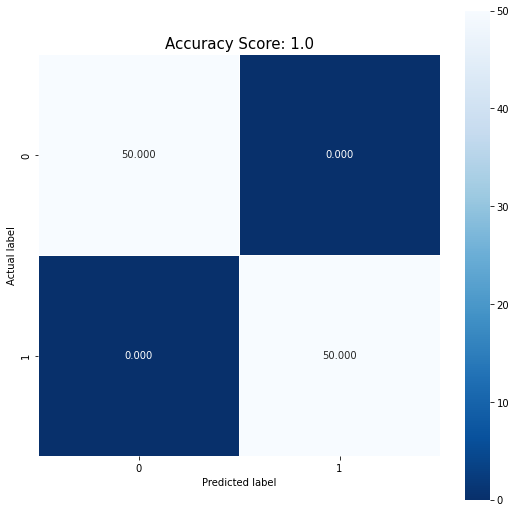

In [693]:
Forest = RF(X_train, y_train, X_test, y_test)
mat_of_conf(y_test,Forest)

##### Iterating over different regions

In [ ]:
import warnings
warnings.filterwarnings('ignore')
from cmath import isnan

#putanja = "C:/Users/Zephyrus/Desktop/cnn data/data"
putanja = "C:/Users/m.nedeljkovic/Desktop/cnn data/data"
mat_load, roi_load, ind_load, list1, list2, list3, list4 = load_data()

for br1 in range(1,13):
    for br2 in range(1,13):
        if(br1!=br2):
            print("Trained on region " + str(br1) + ", and tested on region " + str(br2))

            for file_name in os.listdir(putanja):
                # construct full file path
                file = putanja + "/" + file_name
                os.remove(file)

            mat_load, roi_load, ind_load, list1, list2, list3, list4 = load_data()
            data_per_trial(1, mat_load, roi_load, ind_load, list1, list2, list3, list4)

            #niz od podataka za svaku sekvencu (podatak je niz od id-ja, sekvence i labele)
            podaci = ucitavanje_podataka(putanja)
            vektorizovani_podaci = vektorizacija(podaci)

            X_train, y_train, X_test, y_test = podela_podataka(vektorizovani_podaci)
            X_train = np.array(X_train, dtype=object)
            y_train = np.array(y_train)
            X_test = np.array(X_test, dtype=object)
            y_test = np.array(y_test)

            X_tr = []
            for i in X_train:
                temp = []
                for j in i:
                    for k in j:
                        if(isnan(k)):
                            k = 0
                        temp.append(k)
                X_tr.append(temp)
            X_train = np.array(X_tr, dtype=object)

            X_ts = []
            for i in X_test:
                temp = []
                for j in i:
                    for k in j:
                        if(isnan(k)):
                            k = 0
                        temp.append(k)
                X_ts.append(temp) 
            X_test = np.array(X_ts, dtype=object)
            Forest = RF(X_train, y_train, X_test, y_test)
            mat_of_conf(y_test,Forest,br1,br2)


### Iterating over different sessions knn and rf

In [696]:
import warnings
warnings.filterwarnings('ignore')

#putanja = "C:/Users/Zephyrus/Desktop/cnn data/data"
putanja = "C:/Users/m.nedeljkovic/Desktop/cnn data/data"

mat_load, roi_load, ind_load, list1, list2, list3, list4 = load_data()

for tr in range(1,13):

    X_train, X_test, y_train, y_test = [], [], [], []

    br1 = 3
    for br in [0,1,2]:

        for file_name in os.listdir(putanja):
            # construct full file path
            file = putanja + "/" + file_name
            os.remove(file)

        data_per_ses(tr, br, mat_load, roi_load, ind_load, list1, list2, list3, list4)
        podaci = ucitavanje_podataka(putanja)
        vektorizovani_podaci = vektorizacija(podaci)
        X_train_, y_train_ = podela_podataka_tren(vektorizovani_podaci)
        X_tr = []
        for i in X_train_:
            temp = []
            for j in i:
                for k in j:
                    if(isnan(k)):
                        k = 0
                    temp.append(k)
            X_tr.append(temp)
        X_train_ = np.nan_to_num(X_tr)

        for mm in X_train_:
            X_train.append(mm)
        for mm in y_train_:
            y_train.append(mm)

    for file_name in os.listdir(putanja):
        # construct full file path
        file = putanja + "/" + file_name
        os.remove(file)

    data_per_ses(tr, br1, mat_load, roi_load, ind_load, list1, list2, list3, list4)
    podaci = ucitavanje_podataka(putanja)
    vektorizovani_podaci = vektorizacija(podaci)
    X_train_, y_train_ = podela_podataka_tren(vektorizovani_podaci)
    X_tr = []
    for i in X_train_:
        temp = []
        for j in i:
            for k in j:
                if(isnan(k)):
                    k = 0
                temp.append(k)
        X_tr.append(temp)
    X_train_ = np.nan_to_num(X_tr)

    for mm in X_train_:
        X_test.append(mm)
        
    for mm in y_train_:
        y_test.append(mm)
    
    X_train = np.array(X_train, dtype=object)
    y_train = np.array(y_train)
    X_test = np.array(X_test, dtype=object)
    y_test = np.array(y_test)
            
    knn = OneVsRestClassifier(KNeighborsClassifier())
    knn.fit(X_train,y_train)
    predictions = knn.predict(X_test)
    knn_acc = accuracy_score(y_test,predictions)

    Forest = RF(X_train, y_train, X_test, y_test)
    rf = accuracy_score(y_test,Forest)

    model = xgb.XGBClassifier(objective ='reg:linear', colsample_bytree = 0.3, learning_rate = 0.1, max_depth = 5, alpha = 0.1, n_estimators = 12,  eta=0.05)
    model.fit(X_train, y_train)

    # make predictions for test set
    y_pred = model.predict(X_test)
    predictions = [round(value) for value in y_pred]

    accuracy = accuracy_score(y_test, predictions)

    print("KNN: ", knn_acc)
    print("RF: ", rf)
    print("XGB: ", accuracy)

    break


Accuracy: 0.600
[17:53:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
KNN:  0.59
RF:  0.6
XGB:  0.6


## Classification on 5 different speakers

#### Data preparation

In [18]:
def ucitavanje_sp(directory):
    id = 0
    data = []
    for filename in os.listdir(directory):
        f = os.path.join(directory, filename)
        label = [int(f.split("\\")[-1][-5:-4])]
        id = id + 1
        dat = np.load(f)
        data.append([id, dat, label])
    
    #random.seed(2)
    random.shuffle(data)
    return data      

In [19]:
def podela_podataka_sp(data_vectors):
    
    max = 0
    for i in range(0,len(data_vectors)):
        if(data_vectors[i][1].shape[0] > max):
            max = data_vectors[i][1].shape[0]

    max_norm = 0
    min_norm = 50
    for a in data_vectors:
        for x in a[1]:
            for y in x:
                if(y > max_norm):
                    max_norm = y
                if(y < min_norm):
                    min_norm = y

    for a in range(0, len(data_vectors)):
        for x in range(0, len(data_vectors[a][1])):
            for y in range(0, len(data_vectors[a][1][x])):
                data_vectors[a][1][x][y] = (data_vectors[a][1][x][y] - min_norm) / (max_norm - min_norm)


    X_train, y_train, X_test, y_test = np.empty([1, max, data_vectors[0][1].shape[1]]), [], np.empty([1, max, data_vectors[0][1].shape[1]]),[]
    
    i1,i2,i3,i4,i5 = 0,0,0,0,0

    random.shuffle(data_vectors)
    for item in data_vectors:

        if item[2]==[0]:
            i1 = i1 + 1
            if i1 <= 50:
                if(np.array(item[1]).shape[0] < max):
                    item[1] = np.pad(item[1], [(0, max-np.array(item[1]).shape[0]), (0, 0)], mode='constant' , constant_values=0)
                X_test = np.append(X_test, item[1].reshape(1, item[1].shape[0], item[1].shape[1]), axis=0)
                y_test.append([0])
                #y_test.append(random.choice([[0], [1]]))
            else:
                if(np.array(item[1]).shape[0] < max):
                    item[1] = np.pad(item[1], [(0, max-np.array(item[1]).shape[0]), (0, 0)], mode='constant', constant_values=0)
                X_train = np.append(X_train, item[1].reshape(1, item[1].shape[0], item[1].shape[1]), axis=0)
                y_train.append([0])
            '''
            elif item[2]==[1]:
                i2 = i2 + 1
                if  i2 <= 50:
                    if(np.array(item[1]).shape[0] < max):
                        item[1] = np.pad(item[1], [(0, max-np.array(item[1]).shape[0]), (0, 0)], mode='constant', constant_values=0)
                    X_test = np.append(X_test, item[1].reshape(1, item[1].shape[0], item[1].shape[1]), axis=0)
                    y_test.append(item[2])
                    #y_test.append(random.choice([[0], [1]]))
                else:
                    if(np.array(item[1]).shape[0] < max):
                        item[1] = np.pad(item[1], [(0, max-np.array(item[1]).shape[0]), (0, 0)], mode='constant', constant_values=0)
                    X_train = np.append(X_train, item[1].reshape(1, item[1].shape[0], item[1].shape[1]), axis=0)
                    y_train.append(item[2])
            elif item[2]==[2]:
                i3 = i3 + 1
                if  i3 <= 50:
                    if(np.array(item[1]).shape[0] < max):
                        item[1] = np.pad(item[1], [(0, max-np.array(item[1]).shape[0]), (0, 0)], mode='constant', constant_values=0)
                    X_test = np.append(X_test, item[1].reshape(1, item[1].shape[0], item[1].shape[1]), axis=0)
                    y_test.append(item[2])
                    #y_test.append(random.choice([[0], [1]]))
                else:
                    if(np.array(item[1]).shape[0] < max):
                        item[1] = np.pad(item[1], [(0, max-np.array(item[1]).shape[0]), (0, 0)], mode='constant', constant_values=0)
                    X_train = np.append(X_train, item[1].reshape(1, item[1].shape[0], item[1].shape[1]), axis=0)
                    y_train.append(item[2])
                '''
        elif item[2]==[4]:
            i4 = i4 + 1
            if  i4 <= 50:
                if(np.array(item[1]).shape[0] < max):
                    item[1] = np.pad(item[1], [(0, max-np.array(item[1]).shape[0]), (0, 0)], mode='constant', constant_values=0)
                X_test = np.append(X_test, item[1].reshape(1, item[1].shape[0], item[1].shape[1]), axis=0)
                y_test.append([1])
                #y_test.append(random.choice([[0], [1]]))
            else:
                if(np.array(item[1]).shape[0] < max):
                    item[1] = np.pad(item[1], [(0, max-np.array(item[1]).shape[0]), (0, 0)], mode='constant', constant_values=0)
                X_train = np.append(X_train, item[1].reshape(1, item[1].shape[0], item[1].shape[1]), axis=0)
                y_train.append([1])
        '''
        else:
            i5 = i5 + 1
            if  i5 <= 50:
                if(np.array(item[1]).shape[0] < max):
                    item[1] = np.pad(item[1], [(0, max-np.array(item[1]).shape[0]), (0, 0)], mode='constant', constant_values=0)
                X_test = np.append(X_test, item[1].reshape(1, item[1].shape[0], item[1].shape[1]), axis=0)
                y_test.append(item[2])
                #y_test.append(random.choice([[0], [1]]))
            else:
                if(np.array(item[1]).shape[0] < max):
                    item[1] = np.pad(item[1], [(0, max-np.array(item[1]).shape[0]), (0, 0)], mode='constant', constant_values=0)
                X_train = np.append(X_train, item[1].reshape(1, item[1].shape[0], item[1].shape[1]), axis=0)
                y_train.append(item[2])
        '''
    
    X_train = np.array(X_train[1:])
    y_train = np.array(y_train)
    X_test = np.array(X_test[1:])
    y_test = np.array(y_test)
    
    return X_train, y_train, X_test, y_test

#### Test / Train set

In [52]:
putanja = "C:/Users/Zephyrus/Desktop/cnn data/data"
#putanja = "C:/Users/m.nedeljkovic/Desktop/cnn data/data"
#niz od podataka za svaku sekvencu (podatak je niz od id-ja, sekvence i labele)
podaci = ucitavanje_sp(putanja)
X_train, y_train, X_test, y_test = podela_podataka_sp(podaci)

X_train = np.array(X_train, dtype=object)
y_train = np.array(y_train)
X_test = np.array(X_test, dtype=object)
y_test = np.array(y_test)

In [53]:
X_tr = []
for i in X_train:
    temp = []
    for j in i:
        for k in j:
            if(isnan(k)):
                k = 0
            temp.append(k)
    X_tr.append(temp)
X_train = np.array(X_tr, dtype=object)

X_ts = []
for i in X_test:
    temp = []
    for j in i:
        for k in j:
            if(isnan(k)):
                k = 0
            temp.append(k)
    X_ts.append(temp) 
X_test = np.array(X_ts, dtype=object)

### KNN

In [54]:
knn = OneVsRestClassifier(KNeighborsClassifier())
knn.fit(X_train,y_train)

OneVsRestClassifier(estimator=KNeighborsClassifier())

In [55]:
predictions = knn.predict(X_test)

In [56]:
print('KNN Accuracy: %.3f' % accuracy_score(y_test,predictions))

KNN Accuracy: 0.680


Text(0.5, 1.0, 'Accuracy Score: 0.68')

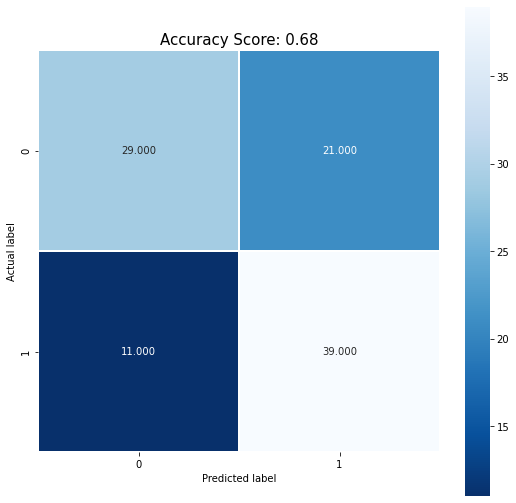

In [57]:
cm = confusion_matrix(y_test,predictions)
plt.figure(figsize=(9,9))
sns.heatmap(cm,annot=True, fmt='.3f', linewidths=.5, square=True,cmap='Blues_r')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
all_sample_title = 'Accuracy Score: {0}'.format(accuracy_score(y_test,predictions))
plt.title(all_sample_title,size=15)

### Random Forest

In [58]:
def RF(X_train, y_train, X_test, y_test):
    forest = RandomForestClassifier(criterion='gini',
                                    n_estimators=5,
                                    random_state=1,
                                    n_jobs=2)
    forest.fit(X_train, y_train)
    y_pred = forest.predict(X_test)
    print('Accuracy: %.3f' % accuracy_score(y_test, y_pred))
    return y_pred

In [59]:
def mat_of_conf(y_test,y_pred):
    cm = confusion_matrix(y_test,y_pred)
    plt.figure(figsize=(9,9))
    sns.heatmap(cm,annot=True, fmt='.3f', linewidths=.5, square=True,cmap='Blues_r')
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    all_sample_title = 'Accuracy Score: {0}'.format(accuracy_score(y_test,y_pred))
    plt.title(all_sample_title,size=15)
    plt.show()

<ipython-input-58-c49a94840cfd>:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  forest.fit(X_train, y_train)


Accuracy: 0.600


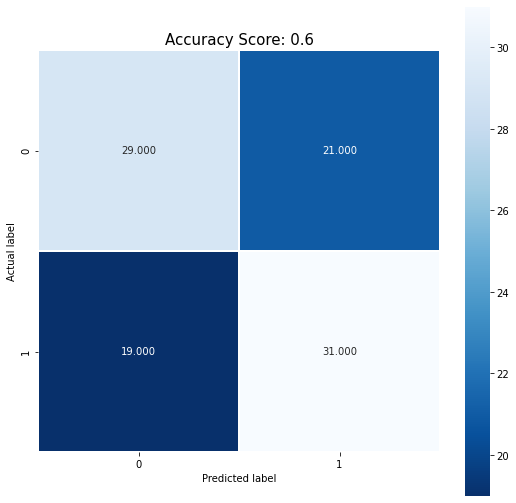

In [60]:
Forest = RF(X_train, y_train, X_test, y_test)
mat_of_conf(y_test,Forest)

### XG boost

[02:59:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-logloss:0.64351	validation_1-logloss:0.67752


c:\Users\Zephyrus\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\Users\Zephyrus\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Zephyrus\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	validation_0-logloss:0.59955	validation_1-logloss:0.66545
[2]	validation_0-logloss:0.55263	validation_1-logloss:0.65716
[3]	validation_0-logloss:0.52123	validation_1-logloss:0.65175
[4]	validation_0-logloss:0.48835	validation_1-logloss:0.64918
[5]	validation_0-logloss:0.45626	validation_1-logloss:0.64723
[6]	validation_0-logloss:0.43343	validation_1-logloss:0.64033
[7]	validation_0-logloss:0.41140	validation_1-logloss:0.64181
[8]	validation_0-logloss:0.39001	validation_1-logloss:0.64199
[9]	validation_0-logloss:0.36946	validation_1-logloss:0.64043
[10]	validation_0-logloss:0.35372	validation_1-logloss:0.63750
[11]	validation_0-logloss:0.34116	validation_1-logloss:0.64129
[12]	validation_0-logloss:0.32685	validation_1-logloss:0.64472
[13]	validation_0-logloss:0.31508	validation_1-logloss:0.64450
[14]	validation_0-logloss:0.30415	validation_1-logloss:0.64705
Accuracy: 0.720


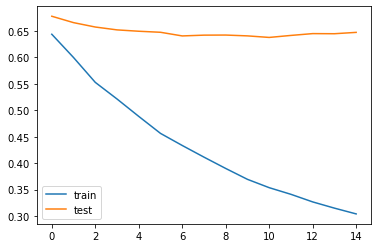

In [61]:
eval = [(X_train, y_train),(X_test, y_test)]
classif = xgb.XGBClassifier(objective ='reg:linear', colsample_bytree = 0.3, learning_rate = 0.1, max_depth = 5, alpha = 0.1, n_estimators = 15,  eta=0.05)
classif.fit(X_train,y_train, eval_set = eval, eval_metric='logloss')
preds = classif.predict(X_test)
score = accuracy_score(y_test, preds)
print('Accuracy: %.3f' % score)
results = classif.evals_result()
# plot learning curves
plt.plot(results['validation_0']['logloss'], label='train')
plt.plot(results['validation_1']['logloss'], label='test')
plt.legend()
plt.show()

In [62]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

#instantiate model and train
model = xgb.XGBClassifier(objective ='reg:linear', colsample_bytree = 0.3, learning_rate = 0.1, max_depth = 5, alpha = 0.1, n_estimators = 20,  eta=0.05)
model.fit(X_train, y_train)

# make predictions for test set
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]

accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

c:\Users\Zephyrus\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\Users\Zephyrus\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Zephyrus\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[02:59:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
Accuracy: 70.00%


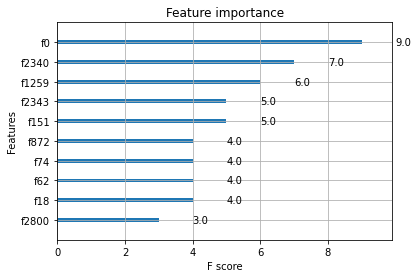

In [63]:
from turtle import width
from xgboost import plot_importance
import matplotlib.pyplot as plt

# plot feature importance
plot_importance(model, max_num_features=10)
plt.show()

x = model.feature_importances_

In [64]:
max(x)

0.042291746